## Solving the CartPole problem with Deep Q Networks and Experience Replay:

Improvements:
- [ ] Use fitted Q targets
- [x] Improve plotting, add tqdm loss bar
- [x] Add render of the environment -> in a different file

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from IPython.display import clear_output
import random

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, ReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
env = gym.envs.make('CartPole-v1')
input_shape = 4

In [9]:
# defining a NN here:

def create_model(input_shape, num_actions=2, loss='mean_squared_error'):
    model = Sequential()
    
    model.add(Dense(32, input_shape=(input_shape, ), activation='relu', kernel_initializer='RandomNormal'))
    model.add(Dense(32, activation='relu',  kernel_initializer='RandomNormal'))     
    model.add(Dense(num_actions))     
    
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss=loss)    
    
    return model

In [10]:
class DQN(object):
    ''' Deep Q Network implentation using Keras.
    '''
    def __init__(self, model, num_actions):
        self.num_actions = num_actions
        self.model = model
        self.basic_params = {
            "num_episodes": 100,
            "epsilon": 0.3,
            "rep_size": 64,
            "discount_factor": 0.9,
            "eps_decay": 0.99,
            "min_eps": 0.01
        }
            
    def predict(self, state):
        return self.model.predict(state.reshape(1, -1))
    
    def update(self, state, target):
        self.model.fit(state.reshape(1, -1), target.reshape(1, -1), epochs=1, verbose=False)
        
    def epsilon_greedy_policy(self, state, epsilon):
        probs = np.ones(self.num_actions) * epsilon / self.num_actions
        q_vals = self.predict(state)[0]
        probs[np.argmax(q_vals)] += 1 - epsilon
        return probs
        
    def plot_report(self, losses, rewards):
        clear_output(wait=True)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
        fig.suptitle('Deep Q Network')
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('MSE Loss')
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('Reward')
        ax[1].axhline(195, c='red',ls='--', label='goal')        
        ax[1].axhline(np.mean(rewards[-100:]), c='green',ls='--', label='average reward')        
        ax[0].plot(losses)        
        ax[1].plot(rewards, label='reward')
        ax[0].grid()
        ax[1].grid()
        ax[1].legend()
        plt.show()
        
    def update_mem(self, memory, discount_factor, rep_size):
        if len(memory) >= rep_size:
            mem = random.sample(memory, rep_size)
            inputs = np.array([ex[0] for ex in mem])
            targets = np.array([self.predict(ex[0])[0] for ex in mem])
            
            for y in range(len(targets)):
                state, action, reward, next_state, done = mem[y]
                targets[y][action] = reward
                # if it's not terminal                
                if not done: 
                    targets[y][action] += discount_factor * np.max(self.predict(next_state)[0])
            
            hist = self.model.fit(inputs, targets, epochs=1, verbose=False)
            return round(hist.history['loss'][0], 3)
    
    def solve(self, env, params=None, plot=False, plot_final=False):
        if not params:
            params = self.basic_params
        
        losses, rewards, memory  = [], [], []
        cur_epsilon = params["epsilon"]
        tr = tqdm.trange(params["num_episodes"], desc='MSE ', leave=True)
        
        for _ in tr:
            state = env.reset()
            done = False
            tot_r, tot_l, length = 0, 0, 0
            while not done:
                #probs = self.epsilon_greedy_policy(state, cur_epsilon)
                #action = np.random.choice(np.arange(self.num_actions), p=probs)
                if random.random() < cur_epsilon:
                    action = random.randint(0, 1)
                else:
                    action = np.argmax(self.predict(state)[0])

                next_state, reward, done, _ = env.step(action)
                memory.append((state, action, reward, next_state, done))

                loss = self.update_mem(memory, params["discount_factor"], params["rep_size"])
                tr.set_description(f"MSE Loss - {loss}")
                tr.refresh()  
        
                tot_r += reward
                tot_l += loss if loss else 0
                length += 1
                state = next_state
            
            cur_epsilon = max(params["min_eps"], cur_epsilon * params["eps_decay"])            
            losses.append(tot_l/length)
            rewards.append(tot_r)
            
            if plot:
                self.plot_report(losses, rewards)    
        
        if plot_final:
            self.plot_report(losses, rewards)    

In [11]:
params = {
    "num_episodes": 300,
    "epsilon": 1,
    "rep_size": 20,
    "discount_factor": 0.95,
    "eps_decay": 0.995,
    "min_eps": 0.01
}

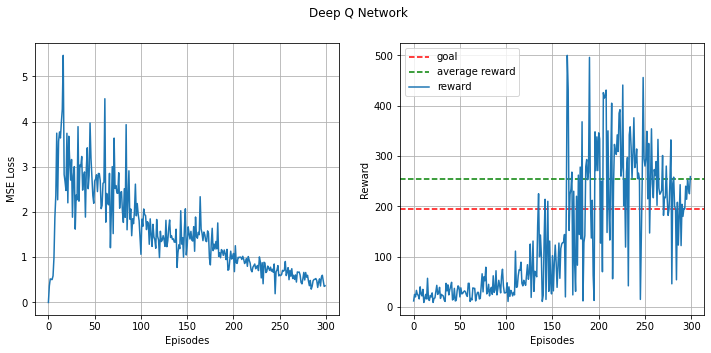

MSE Loss - 0.028: 100%|██████████| 300/300 [37:58<00:00,  7.60s/it]


In [12]:
model = create_model(input_shape=4)
solver = DQN(model, num_actions=2)
solver.solve(env, params=params, plot=True)

In [13]:
# saving the model

model_json = solver.model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

solver.model.save_weights("model.h5")